# Spiking Motif Sorting
## A first step with a mixture of motifs and dimensionality reduction

Different motifs linearly overlap in a raster plot and we treat here the cocktail party problem where results can be two fold: 
- be able to differentiate the different sources
- be able to retrieve the spiking motifs/patterns associated to the different sources

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from untitled import SM_World, plot_SM, plot_raster, make_input_and_plot_sdist, plot_embedding, plot_3d_embedding, plot_corrcoef
from sklearn.decomposition import PCA, NMF, KernelPCA
from sklearn.manifold import MDS, SpectralEmbedding, TSNE, Isomap

/gs/home/grimaldiav/.conda/envs_ppc/ppc-spikeship/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/mnt/pns/home/grimaldiav/Documents/SpikeShip/spikeship/spikeship.py:254: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(int32(int32, int32))


In [3]:
class world_params:
    N_pre = 100 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 2 # number of SM used for RP generation

    p_input = .05 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio)
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM

    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP

    avg_precision = 10 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision

    seed = 4815162342 # seed

## Model with 2 motifs and a linear combination of the 2

Each kernel represents a spiking pattern that will repeat in the raster plot with more or less temporal precision. To simulate the temporal jitter associated to the different spikes of the motif, a gaussian kernel, specific to each spike (this specificity depends on *std_precision*), is used to convolve the all-or-none events (the precision is given by the standard deviation of the gaussian kernel). The mixture of the 2 kernels (here kernel #3) is given with a linear combination of the kernels with coefficients between 0 and 1. They can be normalized (sum=1) or not. 

To draw the input raster plot, we use the different kernels and a bernoulli trial that will give on raster plot for one trial. Such a raster plot (for on trial) corresponds to the time window of the kernel (prior on the detection of the motifs) and motifs can overlap only with 0 time lag. 

In [4]:
opt = world_params()
add_coef = torch.rand([opt.N_kernels])
world = SM_World(opt, add_coef = add_coef)
input_rp, labels = world.draw_input_one_sm()

/mnt/pns/home/grimaldiav/Documents/sms/generative_model/untitled.py:30: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch_1681837271882/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  self.kernels[-1, :, :] = torch.matmul(self.kernels.T,add_coef).T


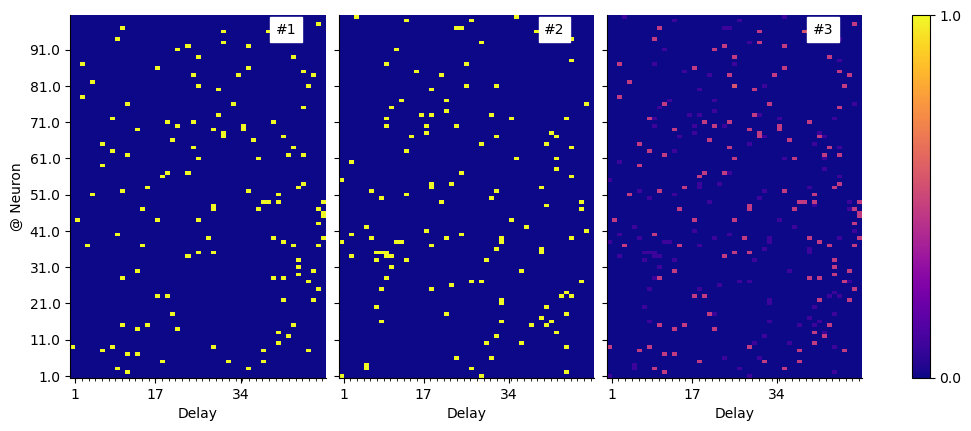

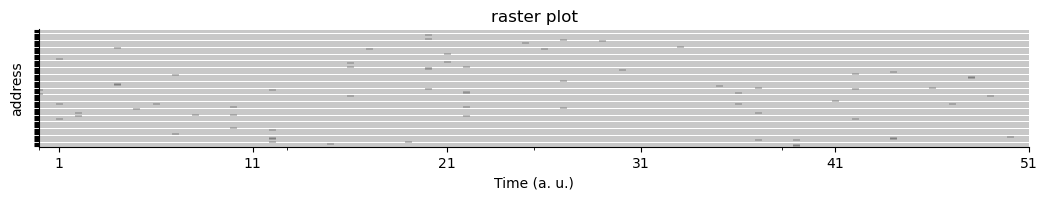

In [5]:
plot_SM(world.kernels, N_show = world.kernels.shape[0], figsize = (12, 5));
plot_raster(input_rp, colored=False);

## Format the ouput for SpikeShip and compute the dissimilarity matrix

Here, data is drawn, the total number of trials is given by $N_{trials}*N_{coef-changes}$ where $N_{coef-changes}$ represents the number of time a new set of linear combination coefficient are randomly selected. If *mixture_only* is *True*, only the last kernel (mixture of patterns) is used to make the raster plots. 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5010/5010 [00:54<00:00, 91.68it/s]


0.09316297544631297% of nan values


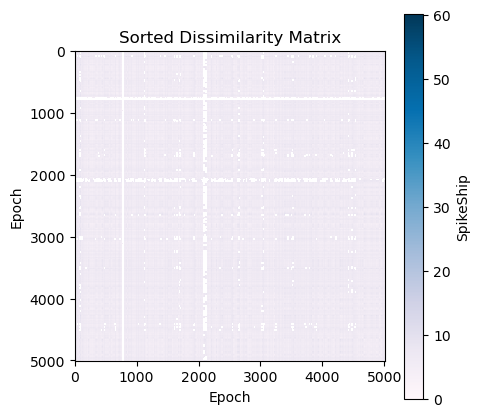

In [6]:
N_trials = 10
N_coef_changes = 500
normalize_coef = False
mixture_only = True
plot = True # to plot the dissimilarity matrix given by SpikeShip
input_rp, labels, S_dist = make_input_and_plot_sdist(world, N_trials=N_trials, N_coef_changes=N_coef_changes, normalize_coef=normalize_coef, mixture_only=mixture_only, plot=plot)

Here we choose not to give the original patterns but just a lot of different mixtures and how we can retrieve the different components (original patterns).

## Linear dimensionality reduction technique - Decomposition into different components
### PCA decomposition (more results can be found in [PCA notebook](2023-10-04_PCA.ipynb))

In [7]:
number_of_components=opt.N_kernels#-normalize_coef
print(f'Expected number of components {number_of_components}')

Expected number of components 2


CPU times: user 33.2 s, sys: 0 ns, total: 33.2 s
Wall time: 355 ms


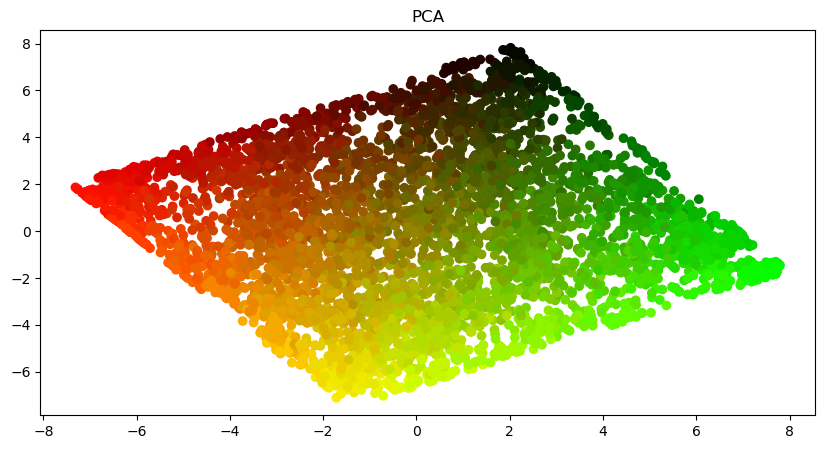

In [8]:
%%time
input_flatten = input_rp.flatten(start_dim=1)
pca = PCA(n_components=number_of_components)
pca_embedding = pca.fit_transform(input_flatten)
plot_embedding(pca_embedding, labels, 'PCA')

PCA seems to solve the separation problem, each dot color is a function of the mixture coefficients that provide the RGB values. Then, each sample is represented as a mixture of the 3 main motifs (red, green, blue). In previous notebook, one could think that PCA used the original kernels that were maybe overrepesented but here there is no true kernel, only different mixtures and PCA seems to able to describe them as a function of the 3 original motifs. 

### Non-negative matrix factorization (more results can be found in [NMF notebook](2023-10-04_NMF.ipynb))

CPU times: user 2min 54s, sys: 35.2 ms, total: 2min 54s
Wall time: 1.48 s


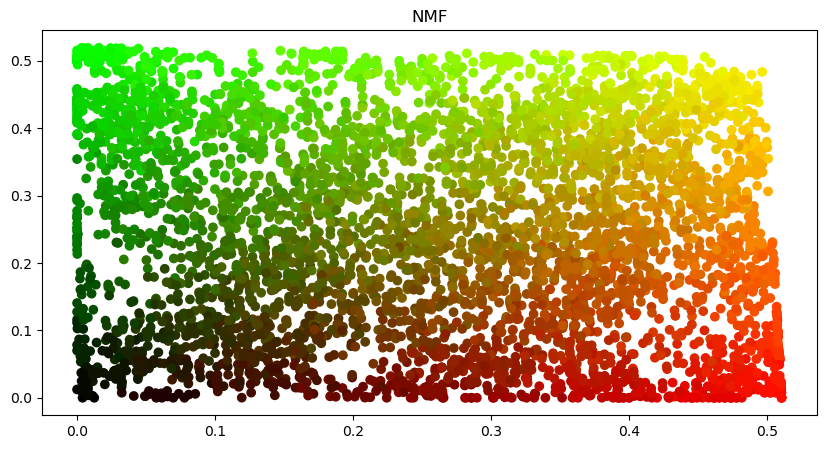

In [9]:
%%time
nmf = NMF(n_components=number_of_components)
nmf_embedding = nmf.fit_transform(input_flatten)
plot_embedding(nmf_embedding, labels, 'NMF')

NMF seems also to be solving the source separation problem

### Trying to retrieve the different components (motifs)
#### For PCA

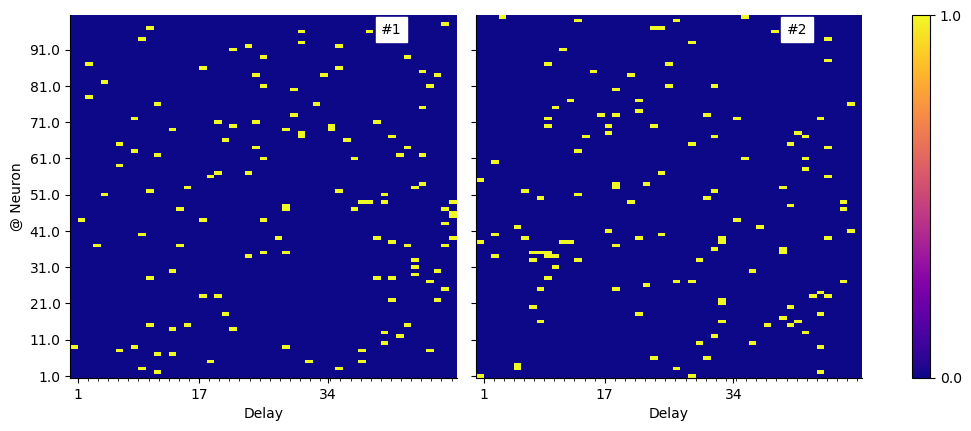

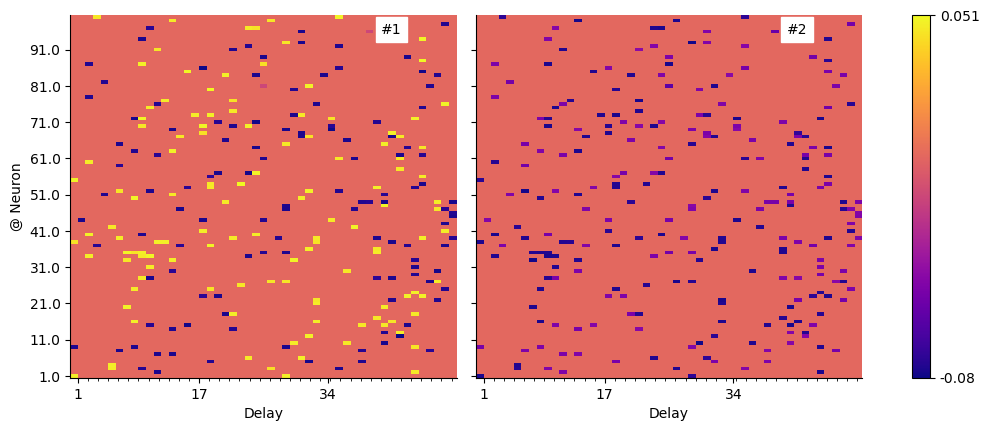

In [10]:
pca.fit(input_flatten)
estimated_kernels = pca.components_
estimated_sms = estimated_kernels.reshape((number_of_components, world.kernels.shape[1], world.kernels.shape[2]))
plot_SM(world.kernels, N_show = number_of_components, figsize = (12, 5));
plot_SM(torch.tensor(estimated_sms), N_show = number_of_components, figsize = (12, 5));

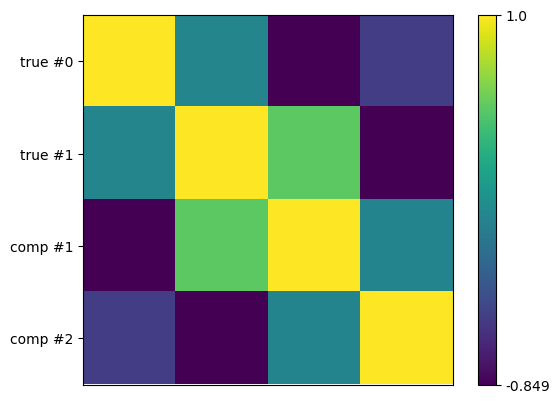

In [11]:
plot_corrcoef(world, estimated_sms)

We use here the correlation matrix between the true kernels used to make the raster plots and the components obtained with the dimensionality reduction techniques. It can be agood indicator because there is no time shift in the motifs that are presented in a fixed window with the same size of the delays. 

PCA seem to obtain a first component correlated with the first true kernel and anti-correlated with the second one. The second one is anti-correlated to both true kernels. 

#### For NMF

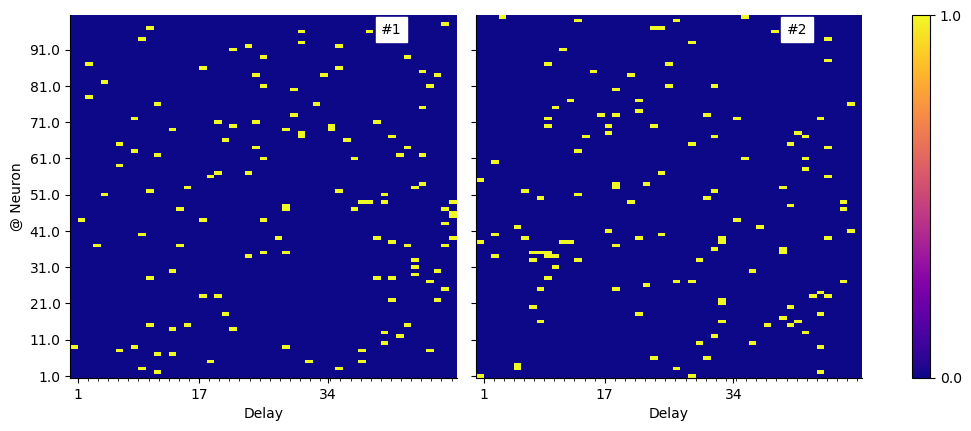

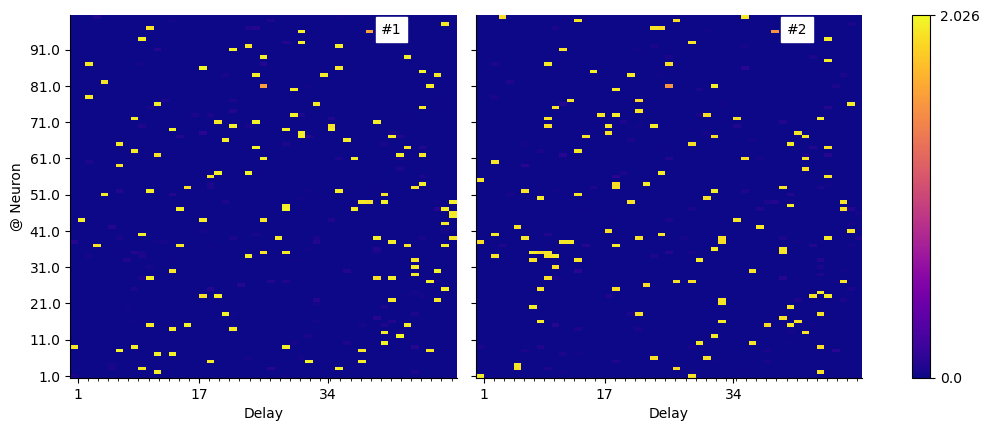

In [12]:
nmf.fit(input_flatten)
estimated_kernels = nmf.components_
estimated_sms = estimated_kernels.reshape((number_of_components, world.kernels.shape[1], world.kernels.shape[2]))
plot_SM(world.kernels, N_show = number_of_components, figsize = (12, 5));
plot_SM(torch.tensor(estimated_sms), N_show = number_of_components, figsize = (12, 5));

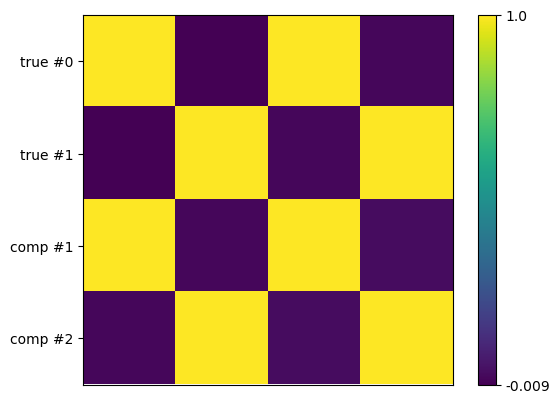

In [13]:
plot_corrcoef(world, estimated_sms)

Here we can see that NMF is able to decompose the signal with the 2 patterns and that the learnt patterns can be assimilated to the original ones (correlation close or equal to 1). 

NMF assumes that input matrices are positive which is correct in this case and it is a superimposition of the kernels as in the cocktail party problem whereas PCA is substracting the different components to get the next ones. 

## Manifold learning
Because SpikeShip is a non-Euclidian metric, results obtained using the dissimilarity matrix can be different and present a manifold learning that is not limited by linear dimensionality reduction. 
### Kernel PCA with SpikeShip

In [14]:
%%time
kpca = KernelPCA(n_components=number_of_components, kernel='precomputed').fit_transform(S_dist)
plot_embedding(kpca, labels, 'kPCA')

ValueError: Input X contains NaN.
KernelPCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Kernel PCA does not bring interesting decomposition with SpikeShip. SpikeShip may not be able to decompose the different kernels with a single dissimilarity metric. An intermediate level decomposition with the neural flow may achieve interesting results (to be checked). 

### Multidimensional scaling [(guide)](https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/)
#### With SpikeShip dissimilarity matrix

In [15]:
%%time
mds = MDS(n_components=number_of_components, dissimilarity='precomputed', normalized_stress='warn')
embedding = mds.fit_transform(S_dist)
plot_embedding(embedding, labels, 'MDS')
mds.stress_

ValueError: Input X contains NaN.
MDS does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [16]:
if number_of_components>2:
    view_init = [0,90]
    plot_3d_embedding(embedding, labels, 'MDS', view_init=view_init)
    view_init = [0,0]
    plot_3d_embedding(embedding, labels, 'MDS', view_init=view_init)
    view_init = [60,60]
    plot_3d_embedding(embedding, labels, 'MDS', view_init=view_init)

#### With euclidian distance on the raster plots

/gs/home/grimaldiav/.conda/envs_ppc/ppc-spikeship/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


CPU times: user 3h 45min 36s, sys: 1h 31min 17s, total: 5h 16min 54s
Wall time: 11min 33s


164536030.50645915

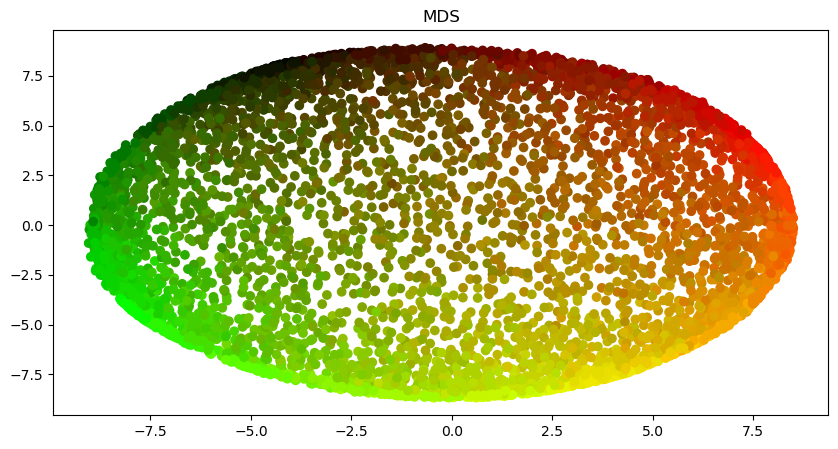

In [17]:
%%time
mds_euclidian = MDS(n_components=number_of_components, dissimilarity='euclidean', normalized_stress='warn')
embedding = mds_euclidian.fit_transform(input_flatten)
plot_embedding(embedding, labels, 'MDS')
mds_euclidian.stress_

MDS seems to be able to find a good manifold to represent the observations as a function of mixture coefficient. However, with this manifold learning it does not seem possible to infer components in the input space. Indeed, MDS matches the pairwise distances in the original space and the ones obtained in the reduced space with the defined number of components (that are not defined in the same space as the raster plots). 

MDS is really long to run compare to the other algorithms.

### Isomap

In [18]:
%%time
isomap = Isomap(n_components=number_of_components, metric='precomputed', n_neighbors=S_dist.shape[0]-1).fit_transform(S_dist)
plot_embedding(isomap, labels, 'Isomap')

ValueError: Input X contains NaN.
NearestNeighbors does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Pretty similar comments as for MDS. This technique is not working locally though (with a reduced number of nearest neighbors for the search). Qualitatively better with the maximum amount of NN.

### Laplacian eigenmaps

In [19]:
%%time
s_embedding = SpectralEmbedding(n_components=number_of_components, affinity='precomputed').fit_transform(S_dist)
plot_embedding(s_embedding, labels, 'Laplacian Eigenmaps')

ValueError: Input X contains NaN.
SpectralEmbedding does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [20]:
%%time
s_embedding = SpectralEmbedding(n_components=number_of_components, n_neighbors=50, affinity='precomputed_nearest_neighbors').fit_transform(S_dist)
plot_embedding(s_embedding, labels, 'Laplacian Eigenmaps')

ValueError: Input X contains NaN.
SpectralEmbedding does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

CPU times: user 6min 7s, sys: 0 ns, total: 6min 7s
Wall time: 3.97 s


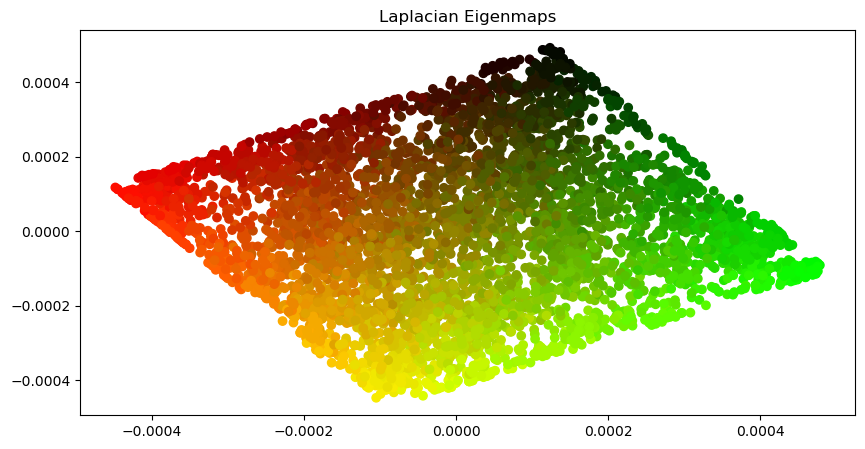

In [21]:
%%time
s_embedding = SpectralEmbedding(n_components=number_of_components, n_neighbors=100, affinity='rbf').fit_transform(input_flatten)
plot_embedding(s_embedding, labels, 'Laplacian Eigenmaps')

The laplacian eigenmaps method does not seem to solve the problem when using SpikeShip as the precomputed metric. 

### t-SNE

In [22]:
%%time
tsne_embedding = TSNE(metric='precomputed', n_components=number_of_components, random_state=0, init='random').fit_transform(S_dist)
plot_embedding(tsne_embedding, labels, 't-SNE')

ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [23]:
if number_of_components>2:
    view_init = [0,90]
    plot_3d_embedding(tsne_embedding, labels, 't-SNE', view_init=view_init)
    view_init = [0,0]
    plot_3d_embedding(tsne_embedding, labels, 't-SNE', view_init=view_init)
    view_init = [60,60]
    plot_3d_embedding(tsne_embedding, labels, 't-SNE', view_init=view_init)

t-SNE does not seem to solve completely the problem even with a different choice of hyperparameters and when trying to apply it on the input and not on the dissimilarity matrix. 

#### Conclusion

From this notebook, we observe that linear decomposition methods are able to efficiently solve the source separation problem. Because the signal is a linear combination of 2 input patterns, these techniques may be more appropriated. And the NMF method is able to estimate the different patterns combined to produce the mixture efficiently unlike PCA for wich the components are only slightly correlated with the true patterns. 

Surprisingly, kernel PCA with SpikeShip as the kernel does not obtain good results. Other manifold learning methods can seperate sources with maybe less efficiency than the linear methods and cannot decompose the signal into different sources because they mainly map the pairwise distances in a lower dimensional space. The spectral embedding technique did not work when using SpikeShip as the metric but could describe the inputs as a combinaison of different sources with the radial basis function as 'affinity'. 

#### TO DO:
- extend to more patterns
- push the limits of the method to see how much samples are needed to recover the kernels
- change the generative model and see if the linear methods are still performing well